# RandomForest Regressor
Haytham Mohamed

INFS 890 - Spring 2020

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [26]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'


#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


test_split = 0.1


In [27]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [28]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.12,0.16,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.40,0.63
1,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.14,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.44,0.62
2,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.15,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.15,0.36,0.62
3,0.09,0.03,0.01,0.02,0.02,0.01,0.01,0.06,0.19,1.00,1.00,1.00,1.00,1.00,1.00,1.54,0.40,0.56
4,0.11,0.04,0.01,0.03,0.03,0.01,0.01,0.11,0.32,1.00,1.00,1.00,1.00,1.00,1.00,2.35,0.78,0.53


In [29]:
data.shape

(1499, 18)

In [30]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 17 features


In [31]:
# Regression

# start:  search grid

randforest = RandomForestRegressor() #(n_estimators=tree_n_estimators, max_features=tree_n_features)

# standardize the features
scaler = StandardScaler()

# no feastures selection needed for RandomTree Regressor
pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('clf', randforest)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'clf__max_features': [11, 9, 7, 5, 3]   # The maximum number of features to consider
    ,'clf__n_estimators': [10, 8, 6, 4, 2, 1]  # The number of trees in the forest 
}


search = GridSearchCV(pipe
                      , param_grid
                      , scoring='neg_mean_squared_error'
                      , return_train_score= True
                      , cv=kfold
                      , verbose=0
                      , n_jobs=-1)

search.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_sampl

# Best Model

In [32]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])

print("")
print('Model training Score = {}'.format(search.score(x_train,y_train)))

Best CV score = -0.018:
Best CV params = {'clf__max_features': 7, 'clf__n_estimators': 8}

[-0.00225853 -0.00242354 -0.00263285 -0.00341052 -0.00493484 -0.00853254
 -0.00215298 -0.00240795 -0.00260771 -0.00324343 -0.00513612 -0.00879167
 -0.00216935 -0.00238351 -0.0026267  -0.00339625 -0.00484081 -0.00917536
 -0.00213907 -0.00251296 -0.00267256 -0.00321544 -0.00504853 -0.00829766
 -0.00227308 -0.00250271 -0.00280557 -0.00359295 -0.00538004 -0.01023522]

Model training Score = -0.002653450268573859


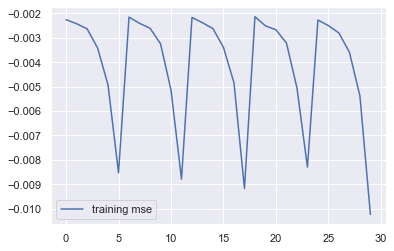

In [33]:
pdf = pd.DataFrame(all_training_scores['mean_train_score'], columns=['training mse'])
pdf.plot()

# Training R2

In [34]:
score = search.score(x_train, y_train)
score

-0.002653450268573859

In [35]:
#scaler.fit(x_train.values.reshape(-1,n_features))
#x_train = scaler.transform(x_train)

y_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))


R2 (training) = 0.9442981272167639


In [36]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.03 (0.04) 0.00 0.41 MSE


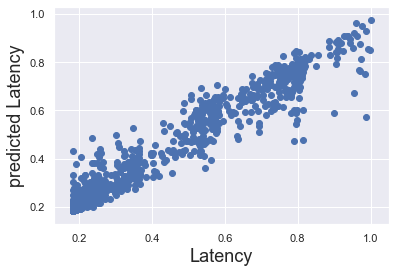

In [37]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

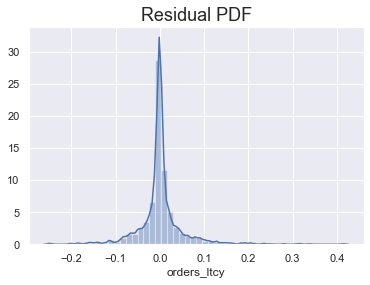

In [38]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [39]:
y_hat_test = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

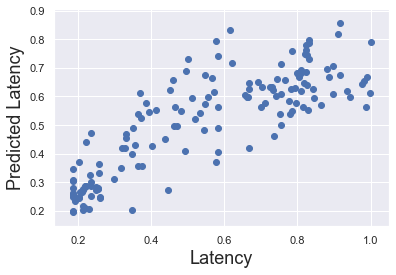

In [40]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

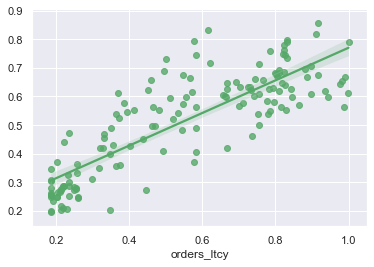

In [41]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [42]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.22,1.20
1,1.23,1.25
2,1.28,1.27
3,1.33,1.28
4,1.31,1.28


In [43]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.22,1.20,0.02,1.27
1,1.23,1.25,-0.01,1.18
2,1.28,1.27,0.02,1.49
3,1.33,1.28,0.04,3.32
4,1.31,1.28,0.03,2.27
...,...,...,...,...
145,1.65,2.13,-0.48,22.61
146,1.85,2.71,-0.87,31.98
147,2.36,2.50,-0.14,5.74
148,1.76,2.69,-0.93,34.67


In [44]:
perf.describe()

,prediction,target,residual,difference%
count,150.00,150.00,150.00,150.00
mean,1.69,1.79,-0.09,11.64
std,0.29,0.46,0.29,8.22
min,1.21,1.20,-0.93,0.14
25%,1.41,1.30,-0.27,4.68
50%,1.75,1.74,-0.02,9.89
75%,1.91,2.21,0.09,17.45
max,2.36,2.72,0.45,34.67


In [45]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
16,1.24,1.24,0.00,0.14
67,1.69,1.68,0.00,0.17
101,1.72,1.71,0.01,0.69
28,1.21,1.20,0.01,0.79
9,1.43,1.44,-0.01,0.87
1,1.23,1.25,-0.01,1.18
15,1.22,1.24,-0.01,1.18
8,1.36,1.35,0.02,1.20
0,1.22,1.20,0.02,1.27
6,1.28,1.30,-0.02,1.31


# Prediction Accuracy

In [46]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.6566697089912784


In [47]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.15142951712373276
